# Tutorial: Instantiating a CSM Camera Model from Image

Goals in this tutorial:

- Generate Image Support Data (ISD) for an image
- Instantiate a CSM camera model
- Perform a simple ground to image call 

-----

!!! info "CSM - The Community Sensor Model"

    For more info on CSM, see
    [Sensor Models](https://astrogeology.usgs.gov/docs/concepts/sensor-models/sensor-models/).

    Also see 
    [Sensor Model Software: USGSCSM](https://astrogeology.usgs.gov/docs/concepts/sensor-models/sensor-model-software/#usgs-community-sensor-model-usgscsm) 
    for the USGS's implementation of CSM in its software.


### 1. Prerequisites, Install Knoten
The `knoten` installation may take a little longer than usual due to the many dependencies (including ALE) involved.

```
conda install -c conda-forge knoten=0.4
```

### 2. Generate an ISD from a Cube
We will use MRO data located in the `data/image_to_ground` folder containing a cube and necessary kernels for ISD (Image Support Data) generation.   
*Note*: If your cube already has attached spice data, do you not have to specify kernels in the `props` param and can pass in an empty dict `{}` instead.

In [21]:
import ale
import json
from knoten import csm
from csmapi import csmapi
import os
import matplotlib.pyplot as plt

# Set local data directory and paths
data_dir = '../data/image_to_ground'
cube_file = os.path.join(data_dir, 'B10_013341_1010_XN_79S172W.cub')
isd_file = os.path.join(data_dir, 'isd_file.json')

# Set local kernel paths
props = {
    'kernels': [
        os.path.join(data_dir, 'B10_013341_1010_XN_79S172W_0.bsp'),
        os.path.join(data_dir, 'B10_013341_1010_XN_79S172W_1.bsp'),
        os.path.join(data_dir, 'mro_ctx_v11.ti'),
        os.path.join(data_dir, 'mro_sc_psp_090526_090601_0_sliced_-74000.bc'),
        os.path.join(data_dir, 'mro_sc_psp_090526_090601_1_sliced_-74000.bc'),
        os.path.join(data_dir, 'mro_sclkscet_00082_65536.tsc'),
        os.path.join(data_dir, 'mro_v16.tf'),
        os.path.join(data_dir, 'naif0012.tls'),
        os.path.join(data_dir, 'pck00008.tpc')
    ]
}

# Generate the ISD string from the cube's label
isd_str = ale.loads(
    label=cube_file,
    formatter="ale",
    props=props,
    indent=2,
    verbose=False,
    only_isis_spice=False,
    only_naif_spice=False
)

# Write the ISD string to file 'isd_file.json'
with open(isd_file, "w") as file:
    file.write(isd_str)

isd_dict = json.loads(isd_str)

### 3. Create a Community Sensor Model
We will use Knoten's implementation of CSM as the library supports line scanner types of sensor models in the usgscsm library.

In [16]:
sensor_model = csm.create_csm(isd_file, verbose=False)

### 4. Convert image coordinates into ground coordinates

In [17]:
# Create an image coordinate at line = 206 and sample = 206
image_coord = csmapi.ImageCoord(206, 206)

# Convert the image coordinates to ground coordinates with desired precision of 0.0
ground_coord = sensor_model.imageToGround(image_coord, 0.0)

# Output the ground coordinates
ground_coord.x, ground_coord.y, ground_coord.z

(-572485.2147458872, -79884.88741760612, -3326939.618401299)

### 5. Convert ground coordinates into image coordinates

In [18]:
# Convert the image coordinates to ground coordinates with desired precision of 0.0
image_coord = sensor_model.groundToImage(ground_coord, 0.0)

# Output the image coordinates
image_coord.line, image_coord.samp

(206.0000000225674, 205.9999999963493)

### 6. Plot the footprint

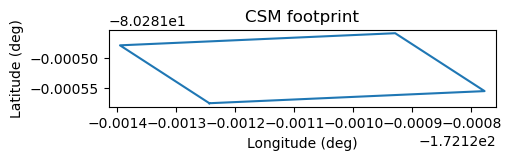

In [ ]:
# Get the footprint using the model
boundary = csm.generate_boundary((isd_dict["image_lines"], isd_dict["image_samples"]))
lons, lats, alts = csm.generate_latlon_boundary(sensor_model, boundary)

# Plot the footprint
def plot_footprint(lons, lats, aspect):
    plt.rcParams["figure.figsize"] = aspect
    plt.axes().set_aspect('equal','datalim')
    plt.plot(lons, lats)
    plt.xlabel("Longitude (deg)")
    plt.ylabel("Latitude (deg)")
    plt.title("CSM footprint")

plot_footprint(lons, lats, [5, 1])